In [1]:
import os
from tqdm.notebook import tqdm
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
glob.glob('*')

['code-regression.ipynb',
 'swaps1m_USDC_ETH_SyncSwap.csv',
 'swaps1m_ETH_BTC_zkSwap.csv',
 'Q3_swaps1m_USDC_ETH_SyncSwap.csv',
 'code-regression-df1.ipynb',
 'swaps1m_USDC_ETH_zkSwap.csv',
 'corr.png',
 'swaps1m_ETH_BTC_SyncSwap.csv']

### Upload data.

In [3]:
df0 = pd.read_csv('swaps1m_USDC_ETH_SyncSwap.csv').dropna()
df0_q3 = pd.read_csv('Q3_swaps1m_USDC_ETH_SyncSwap.csv').dropna()
df1 = pd.read_csv('swaps1m_USDC_ETH_zkSwap.csv').dropna()
df2 = pd.read_csv('swaps1m_ETH_BTC_zkSwap.csv').dropna()
df3 = pd.read_csv('swaps1m_ETH_BTC_SyncSwap.csv').dropna()

In [4]:
# Choose which dataframe to use in the analyses

df = df0
#df = df0_q3

In [5]:
# Subtract LP fees (knowon from volume needed to be traded to get MAV) to MAV
clean_MAV = np.array(df.max_MAV_0) - np.array(df.LP_fee_MAV_0)
df['clean_MAV'] = clean_MAV
# Assure that you are considering only cases with clean_MAV > 0
df = df[df.clean_MAV>0]

len([x for x in clean_MAV if x > 0]), len([x for x in clean_MAV if x <= 0]), len(df[df.max_MAV_0>0])

(116, 5594, 116)

In [6]:
df.columns

Index(['timestamp', 'volume_total_0', 'LP_Fee_total_0',
       'block_slippage_total_0', 'price_diff', 'volume_avg_1m_0',
       'fees_avg_1m_0', 'fees_total_0', 'block_slippage_avg_1m_0',
       'swap_count_1m', 'reserve_0', 'reserve_1', 'spot_price', 'CEX_price',
       'fees_0', 'LP_Fee_0', 'block_slippage_0', 'transactionHash', 'MAV_0',
       'V_max_1', 'V_max_0', 'reserve_total_0', 'LP_fee_MAV_0', 'max_MAV_0',
       'decay', 'max_decay', 'swap_count_upto_max_MAV',
       'block_slippage_sum_upto_max_MAV_0', 'volume_sum_upto_max_MAV_0',
       'fees_sum_upto_max_MAV_0', 'max_decay_min', 'clean_MAV'],
      dtype='object')

### Pre-processing.

In [7]:
to_keep = ['max_decay', 'max_MAV_0', 'clean_MAV',
           'V_max_0', 'LP_fee_MAV_0',
           'fees_sum_upto_max_MAV_0', 'swap_count_upto_max_MAV',
           'block_slippage_sum_upto_max_MAV_0', 'volume_sum_upto_max_MAV_0'
          ]

In [8]:
# _total_ features (in name) are calculated over the 1 minute slot, not the swap

In [9]:
df_reg = df.dropna().loc[:, to_keep]
#df_reg['arbitrage'] = np.array(df_reg.max_MAV_0 > 0).astype(int)
df_reg['avg_gas'] = np.array(df_reg.fees_sum_upto_max_MAV_0)/np.array(df_reg.swap_count_upto_max_MAV)
print(len(df_reg), len(df_reg.dropna()))
df_reg['V0_on_vol_usage'] = np.array(df_reg.V_max_0)/np.array(df_reg.volume_sum_upto_max_MAV_0)
df_reg = df_reg.pad(axis=0).dropna().drop(['fees_sum_upto_max_MAV_0', 
                                             'swap_count_upto_max_MAV',
                                             'block_slippage_sum_upto_max_MAV_0',
                                             'volume_sum_upto_max_MAV_0',
                                             'V_max_0',
                                             'LP_fee_MAV_0'
                                            ], axis=1)
df_reg['max_decay'] = np.abs(list(df_reg.max_decay))
df_reg = df_reg[df_reg.max_decay<1e9]

116 116


/var/folders/nt/p_1jd1pj58z0t11zm9017t340000gn/T/ipykernel_9976/3267824143.py:6: FutureWarning: DataFrame.pad/Series.pad is deprecated. Use DataFrame.ffill/Series.ffill instead
  df_reg = df_reg.pad(axis=0).dropna().drop(['fees_sum_upto_max_MAV_0',


In [10]:
df_reg.describe()

,max_decay,max_MAV_0,clean_MAV,avg_gas,V0_on_vol_usage
count,116.000000,116.000000,116.000000,116.000000,116.000000
mean,2917.758621,547.106098,463.623390,0.350539,32.466793
std,5567.610538,599.793206,568.960266,0.292483,61.756401
min,60.000000,180.437398,135.752783,0.141924,0.315086
25%,180.000000,304.256379,231.291427,0.177665,6.259077
50%,870.000000,365.937934,296.245841,0.240294,14.489090
75%,3180.000000,521.152136,425.543915,0.351045,39.191999
max,36360.000000,3568.297925,3367.369137,1.675070,598.187780


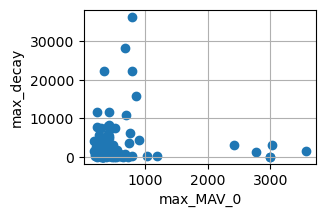

In [11]:
def plot_mav_dec(df_reg):
    
    plt.figure(figsize=(3, 2))
    plt.scatter(df_reg.max_MAV_0, abs(df_reg.max_decay))
    plt.xlabel('max_MAV_0')
    plt.ylabel('max_decay')
    plt.grid()
    plt.show()
    
    return None


plot_mav_dec(df_reg)

In [12]:
feat = df_reg.loc[:, ['clean_MAV', 'avg_gas', 'V0_on_vol_usage', 'max_decay']]

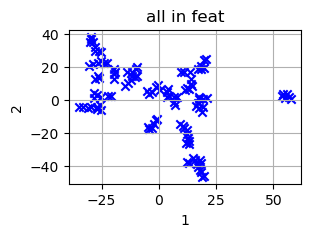

In [13]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X = feat.values
X_std = StandardScaler().fit_transform(X)
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=5).fit_transform(X_std)
plt.figure(figsize=(3, 2))
plt.scatter([x[0] for x in X_embedded], [x[1] for x in X_embedded], marker='x', color='blue')
plt.xlabel('1')
plt.ylabel('2')
plt.grid()
plt.title('all in feat')
plt.show()

[0.32372002 0.26485584 0.23551272 0.17591142]


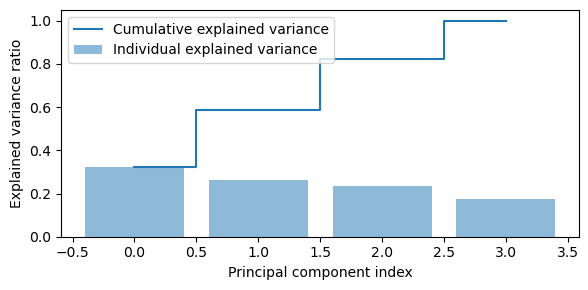

In [14]:
from sklearn.decomposition import PCA
#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X_std)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
print(exp_var_pca)
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.figure(figsize=(6, 3))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

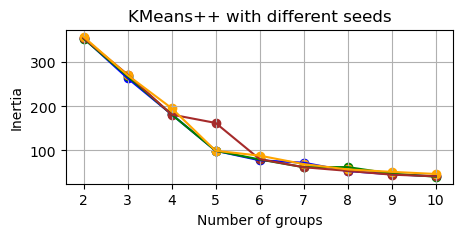

In [15]:
from sklearn.cluster import KMeans

range_ = range(2, 11)
inertias1, inertias2, inertias3, inertias4 = [], [], [], []
for k in range_:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X_std) # random_state=0
    inertias1.append(kmeans.inertia_)
    kmeans = KMeans(n_clusters=k, random_state=17, n_init="auto").fit(X_std) # random_state=0
    inertias2.append(kmeans.inertia_)
    kmeans = KMeans(n_clusters=k, random_state=100, n_init="auto").fit(X_std) # random_state=0
    inertias3.append(kmeans.inertia_)
    kmeans = KMeans(n_clusters=k, random_state=359, n_init="auto").fit(X_std) # random_state=0
    inertias4.append(kmeans.inertia_)
    
plt.figure(figsize=(5, 2))
plt.scatter(range_, inertias1, color='blue')
plt.plot(range_, inertias1, color='blue')
plt.scatter(range_, inertias2, color='green')
plt.plot(range_, inertias2, color='green')
plt.scatter(range_, inertias3, color='brown')
plt.plot(range_, inertias3, color='brown')
plt.scatter(range_, inertias4, color='orange')
plt.plot(range_, inertias4, color='orange')
plt.grid()
plt.xlabel('Number of groups')
plt.ylabel('Inertia')
plt.title('KMeans++ with different seeds')
#plt.savefig('BBG-inertia.png', dpi=300, bbox_inches='tight')
plt.show()



In [16]:
k_good = 5
kmeans = KMeans(n_clusters=k_good, random_state=0, n_init="auto").fit(X_std)
#kmeans.labels_

In [17]:
df_reg['labels'] = kmeans.labels_
#df_reg['labels_d'] = kmeans_d.labels_

In [18]:
df_reg.groupby(['labels']).count()

,max_decay,max_MAV_0,clean_MAV,avg_gas,V0_on_vol_usage
labels,,,,,
0,92,92,92,92,92
1,12,12,12,12,12
2,6,6,6,6,6
3,5,5,5,5,5
4,1,1,1,1,1


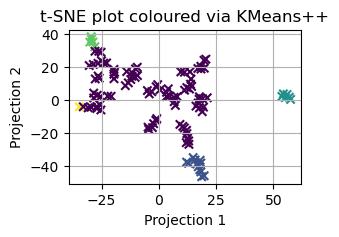

In [22]:
plt.figure(figsize=(3, 2))
plt.scatter([x[0] for x in X_embedded], [x[1] for x in X_embedded], marker='x', c=kmeans.labels_)
plt.xlabel('Projection 1')
plt.ylabel('Projection 2')
plt.grid()
plt.title('t-SNE plot coloured via KMeans++')
plt.show()

In [23]:
for l in range(k_good):
    print('---')
    print(l)
    print(df_reg[df_reg.labels==l].drop(['labels'], axis=1).describe())

---
0
          max_decay    max_MAV_0    clean_MAV    avg_gas  V0_on_vol_usage
count     92.000000    92.000000    92.000000  92.000000        92.000000
mean    2176.956522   396.917600   321.755637   0.254151        27.518744
std     2813.888530   177.352534   160.808785   0.105623        32.440115
min       60.000000   180.437398   135.752783   0.141924         0.315086
25%      180.000000   288.339850   224.553920   0.172665         6.332476
50%      960.000000   348.535125   273.358795   0.228193        14.489090
75%     3195.000000   447.456406   372.128497   0.283999        37.410107
max    11760.000000  1178.509484  1053.683366   0.615026       169.683012
---
1
         max_decay   max_MAV_0   clean_MAV    avg_gas  V0_on_vol_usage
count    12.000000   12.000000   12.000000  12.000000        12.000000
mean    320.000000  430.870133  346.367648   1.068779        19.182464
std     317.833576  168.710671  148.089697   0.300738        19.072527
min      60.000000  223.001053  168.37

In [24]:
dict(df_reg[df_reg.labels==l].drop(['labels', 'max_MAV_0'], axis=1).mean())

{'max_decay': 180.0,
 'clean_MAV': 468.77871868511596,
 'avg_gas': 0.8219521452274999,
 'V0_on_vol_usage': 598.1877799048775}

In [25]:
"""
    Histogram 4 bars (as features) but multiple inner bars (as for different clusters)
"""

dict_means = {'max_decay': [],
             'clean_MAV': [],
             'avg_gas': [],
             'V0_on_vol_usage': []}

for l in range(k_good):
    dd = dict(df_reg[df_reg.labels==l].drop(['labels', 'max_MAV_0'], axis=1).mean())
    for k, v in dd.items():
        dict_means[k].append(v)

In [26]:
df_means = pd.DataFrame.from_dict(dict_means)
df_means['n_points'] = list(df_reg.groupby(['labels']).count().max_decay)
df_means.index.name = 'Group'
df_means

,max_decay,clean_MAV,avg_gas,V0_on_vol_usage,n_points
Group,,,,,
0,2176.956522,321.755637,0.254151,27.518744,92
1,320.000000,346.367648,1.068779,19.182464,12
2,1500.000000,2762.368841,0.466423,45.899195,6
3,25032.000000,595.878215,0.166950,26.130199,5
4,180.000000,468.778719,0.821952,598.187780,1


In [31]:
"""
    Group 3: Extreme max_decay could be evidence that some arbitrage opportunities are not really
    exploited. And we see that it could come from low usage since average gas fees
    witnessed just before the opportunity are also very low.
    
    Group 1: Interestingly, peak of avg_gas comes with lower V0_on_vol_usage, meaning that
    we have network crowded (need to check really what gas fees are dependent upon).
    
    Group 4: lowest decay, but only 1 data point. Interestingly, extreme amount of volume
    desired to be traded against the volume previously witnesses. So, the trader is not much
    worried of adversarial arbitrageurs.
    
    Group 0: Majority of points, average conditions.
    
    Group 2: Greatest MAV opportunities.
"""

df_means_rename = df_means.copy()
df_means_rename.columns = ['time_decay', 'clean_MAV', 'avg_gas', 'Vmax_on_usage', 'n_points']

df_means_rename.style.background_gradient(cmap='Blues')
#sns.heatmap(df_means, cmap='RdYlGn_r', linewidths=0.5, annot=True)

,time_decay,clean_MAV,avg_gas,Vmax_on_usage,n_points
Group,,,,,
0,2176.956522,321.755637,0.254151,27.518744,92
1,320.000000,346.367648,1.068779,19.182464,12
2,1500.000000,2762.368841,0.466423,45.899195,6
3,25032.000000,595.878215,0.166950,26.130199,5
4,180.000000,468.778719,0.821952,598.187780,1


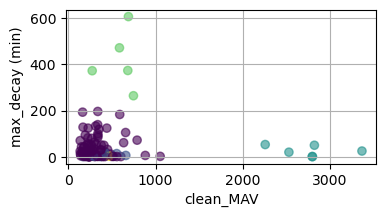

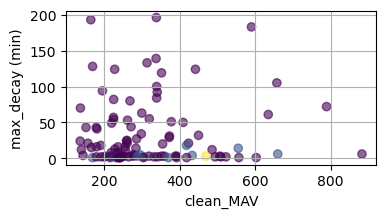

In [34]:
def plot_mav_dec(df_reg):
    
    plt.figure(figsize=(4, 2))
    plt.scatter(df_reg.clean_MAV, np.array(df_reg.max_decay)/60, c=df_reg.labels, alpha=0.6)
    plt.xlabel('clean_MAV')
    plt.ylabel('max_decay (min)')
    plt.grid()
    plt.show()
    
    return None

#plot_mav_dec(df_reg[df_reg.labels==0])
#plot_mav_dec(df_reg[df_reg.labels>0])
plot_mav_dec(df_reg)
plot_mav_dec(df_reg[(df_reg.clean_MAV < 1_000) & (df_reg.max_decay < 60*200)])

---
0


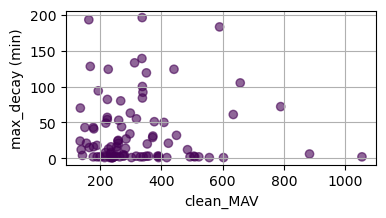

---
1


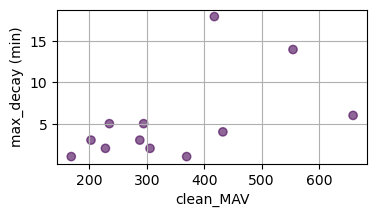

---
2


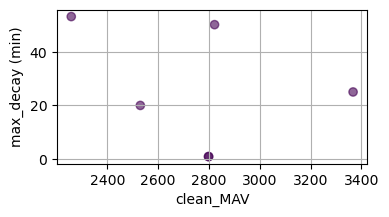

---
3


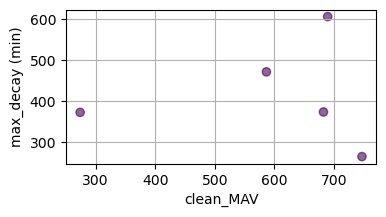

---
4


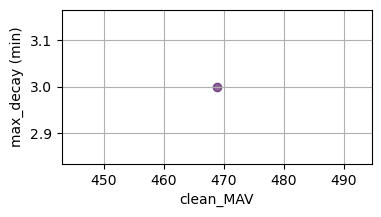

In [35]:
for l in range(k_good):
    print('---')
    print(l)
    
    df_small = df_reg[df_reg.labels == l]
    plot_mav_dec(df_small)#[df_small.max_decay<60*30])

In [36]:
df_test = df_reg[df_reg.labels == 0].drop(['labels', 'max_MAV_0'], axis=1)
df_test['inv_decay'] = 1/np.array(df_test.max_decay)
df_test

,max_decay,clean_MAV,avg_gas,V0_on_vol_usage,inv_decay
66,60.0,242.030632,0.276323,5.426394,0.016667
68,780.0,228.016814,0.282235,10.709303,0.001282
71,360.0,234.707926,0.246471,5.433264,0.002778
85,1200.0,354.477275,0.255202,95.167336,0.000833
184,360.0,882.931226,0.261691,0.315086,0.002778
...,...,...,...,...,...
5671,3240.0,224.276998,0.156775,86.055240,0.000309
5678,3300.0,319.135067,0.154464,7.600612,0.000303
5687,7140.0,351.630325,0.201234,38.922178,0.000140
5698,1080.0,190.586366,0.145806,127.115501,0.000926


In [37]:
df_std = pd.DataFrame(StandardScaler().fit_transform(df_test.values), index=df_test.index, columns=df_test.columns)
#df_std.labels = df_test.labels
df_std

,max_decay,clean_MAV,avg_gas,V0_on_vol_usage,inv_decay
66,-0.756447,-0.498492,0.211069,-0.684751,2.334016
68,-0.499171,-0.586115,0.267348,-0.521008,-0.527859
71,-0.649248,-0.544278,-0.073111,-0.684538,-0.249621
85,-0.349093,0.204597,0.010005,2.096764,-0.611331
184,-0.649248,3.508829,0.071775,-0.843176,-0.249621
...,...,...,...,...,...
5671,0.379855,-0.609499,-0.926975,1.814335,-0.708935
5678,0.401294,-0.016385,-0.948969,-0.617361,-0.709979
5687,1.773431,0.186796,-0.503744,0.353449,-0.740296
5698,-0.391973,-0.820154,-1.031392,3.086996,-0.594107


In [38]:
df_std.columns

Index(['max_decay', 'clean_MAV', 'avg_gas', 'V0_on_vol_usage', 'inv_decay'], dtype='object')

/Users/debbie/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


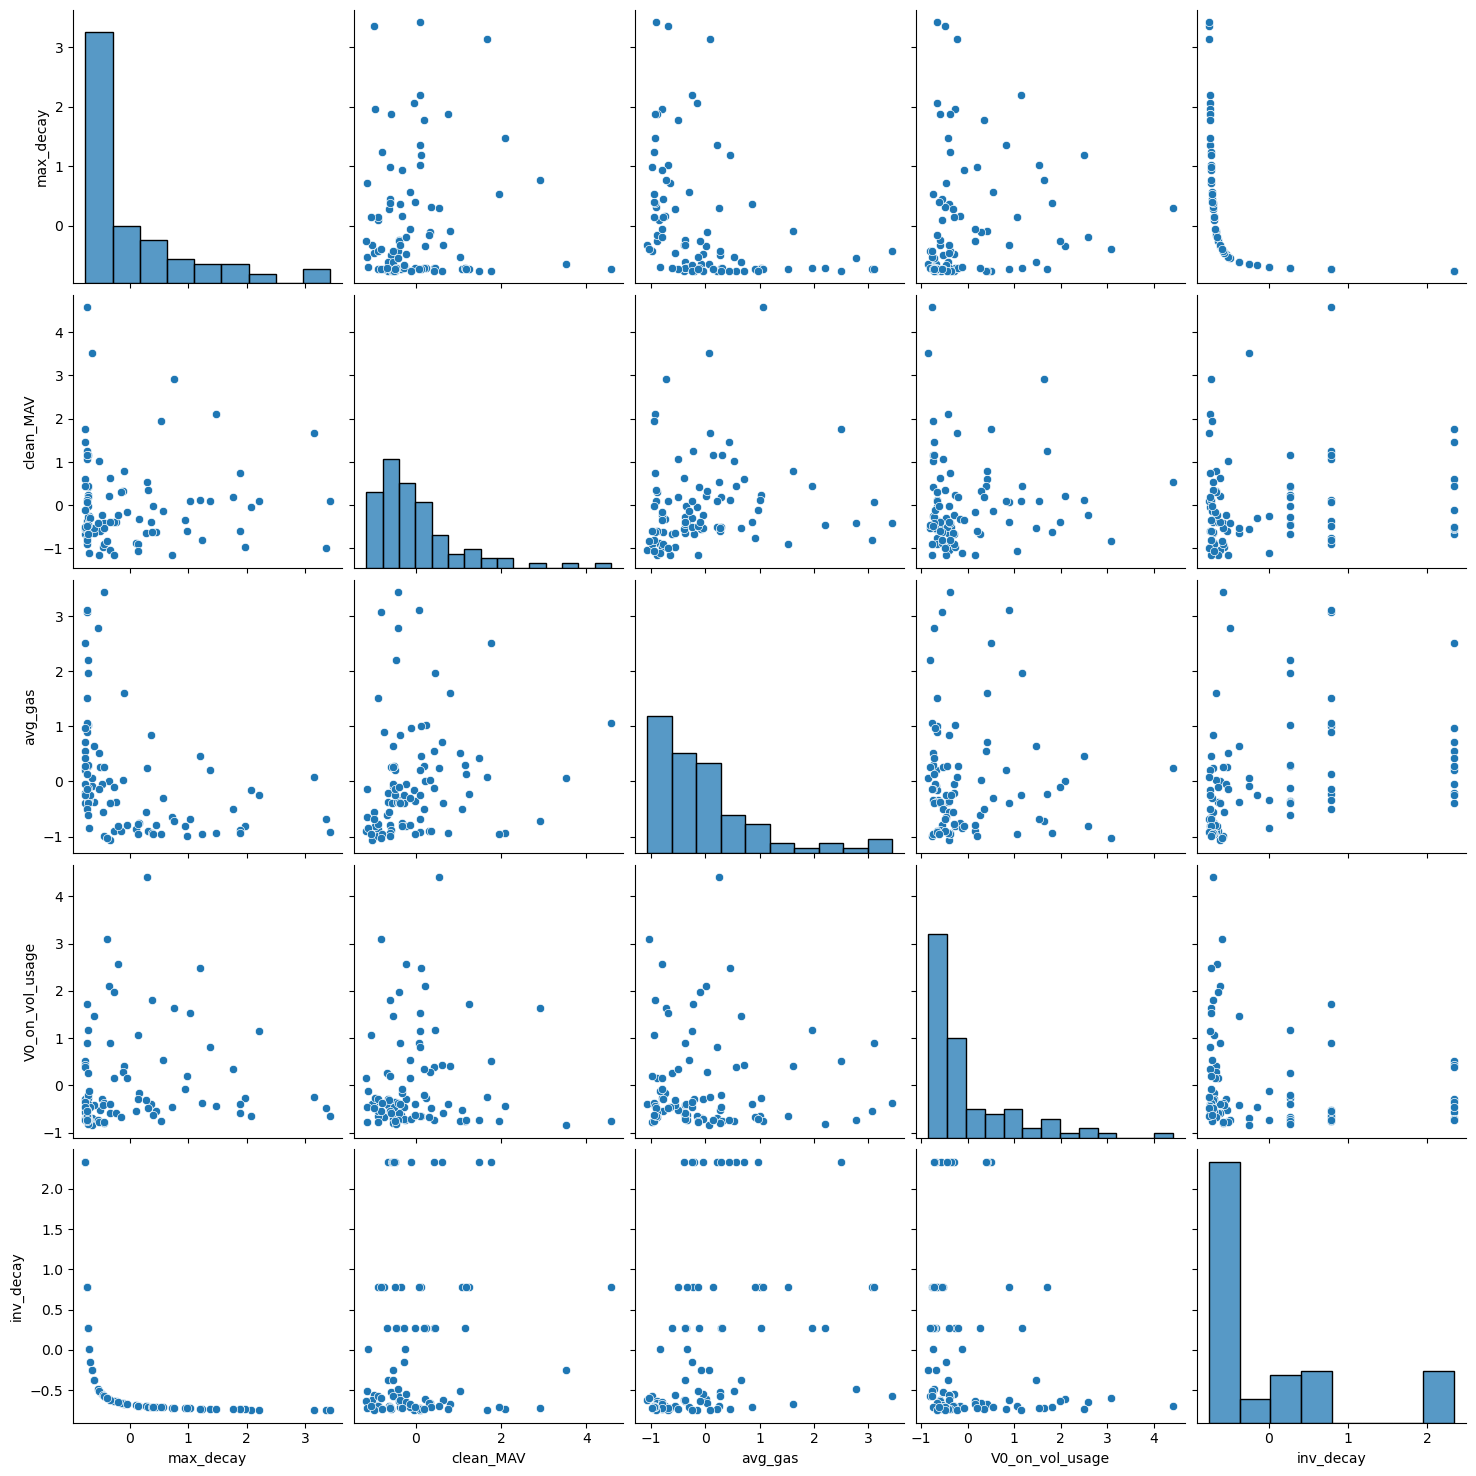

In [39]:
# Seaborn visualization library
import seaborn as sns
# Create the default pairplot
#sns.pairplot(df_reg[df_reg.max_MAV_0 > 1], hue='arbitrage')

#fig, ax = plt.subplots(figsize=(8, 6))
sns.pairplot(df_std,
             #hue = 'labels',
             height=3)
#plt.show()

In [40]:
c = df_test.loc[:, ['clean_MAV', 'avg_gas', 'V0_on_vol_usage', 'max_decay']]
corr = c.corr()
corr

,clean_MAV,avg_gas,V0_on_vol_usage,max_decay
clean_MAV,1.000000,0.145013,0.034106,0.023922
avg_gas,0.145013,1.000000,-0.033128,-0.361198
V0_on_vol_usage,0.034106,-0.033128,1.000000,0.104742
max_decay,0.023922,-0.361198,0.104742,1.000000


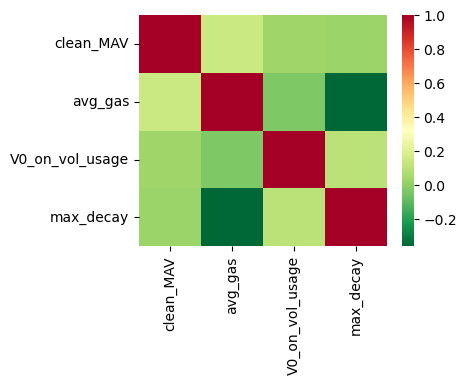

In [41]:
plt.figure(figsize=(4,3))
# plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdYlGn_r')
#plt.savefig('corr', dpi=500, bbox_inches='tight')
plt.show()

In [43]:
df_test = df_test#[df_test.max_decay < 60*120]

In [44]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

########################################

data_exog = df_test.drop(['max_decay'], axis=1)
#data_exog['max_MAV_0_inv'] = 1/np.array(data_exog.max_MAV_0)
#data_exog = data_exog.drop(['max_MAV_0'], axis=1)
y = np.array(df_test.max_decay)

########################################

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(data_exog.values, i) for i in range(data_exog.values.shape[1])]
vif["features"] = data_exog.columns
print(vif.round(1))

########################################

data_exog['clean_MAV'] = np.array(data_exog.clean_MAV)**(-1/2)
#data_exog['clean_MAV'] = np.exp(-1*data_exog.clean_MAV)
data_exog['avg_gas'] = np.array(data_exog.avg_gas)**(-1/2)
#data_exog['e_minus_MAV'] = np.exp(-1*data_exog.clean_MAV)

   VIF Factor         features
0         3.8        clean_MAV
1         4.8          avg_gas
2         1.7  V0_on_vol_usage
3         1.9        inv_decay


In [46]:
10, 10**(-1/2), 10**(-1/3), 100**(-1/2), 100**(-1/3)

(10, 0.31622776601683794, 0.4641588833612779, 0.1, 0.2154434690031884)

In [47]:
10**(-1/2), 100**(-1/2), 1000**(-1/2)

(0.31622776601683794, 0.1, 0.03162277660168379)

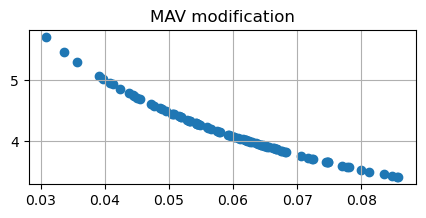

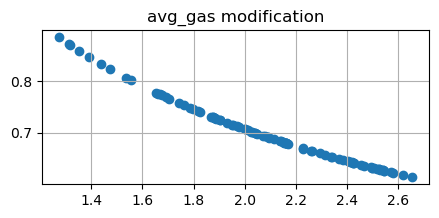

In [48]:
xx = np.array(data_exog.clean_MAV)
yy = np.array(data_exog.clean_MAV)**(-1/2)

plt.figure(figsize=(5, 2))
plt.scatter(xx, yy)
plt.grid()
plt.title('MAV modification')
plt.show()

###

xx = np.array(data_exog.avg_gas)
yy = np.array(data_exog.avg_gas)**(-1/2)

plt.figure(figsize=(5, 2))
plt.scatter(xx, yy)
plt.grid()
plt.title('avg_gas modification')
plt.show()

### Predict and discuss coefficients. The ^(-1/2) modification just re-weights the contribution of features. Still, it makes sense that in the regression MAV needs to have negative coefficient against length of decay and gas fees a positive coefficient.

### It is interesting (and a bit weird) that gas fees are a much more important feature than MAV. However, it can also make some sense. Indeed, MAV is almost money without risk and traders should be interested in getting it anyway whatever the actual value. So, the gas fees to pay could actually be a strong determinant of the time to decay. And remember that price difference can decay also for exogeneous reasons, i.e. people trading in the two "useful" directions on the respective platforms without looking exactly for arbitrage.

## What to investigate next could be how many of these MAV opportunities are indeed exploited in reality by looking at the swaps themselves.

### Durbin-Watson is okk, and p-value as not too bad... R-squared kind of good.

In [49]:
from sklearn import preprocessing
import statsmodels.api as sm

data_exog_proc = preprocessing.scale(data_exog.loc[:, ['clean_MAV', 
                                                       'avg_gas', 
                                                       #'V0_on_vol_usage'
                                                      ]], with_mean=False, with_std=True)

data_exog_proc = sm.add_constant(data_exog_proc, prepend=False)
res = sm.OLS(y, data_exog_proc).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.172
Method:                 Least Squares   F-statistic:                     10.44
Date:                Mon, 04 Mar 2024   Prob (F-statistic):           8.42e-05
Time:                        14:04:06   Log-Likelihood:                -851.03
No. Observations:                  92   AIC:                             1708.
Df Residuals:                      89   BIC:                             1716.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -418.7701    277.568     -1.509      0.1

In [58]:
# alternatively
for table in res.summary().tables:
    print(table.as_latex_tabular())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}    &        y         & \textbf{  R-squared:         } &    0.190  \\
\textbf{Model:}            &       OLS        & \textbf{  Adj. R-squared:    } &    0.172  \\
\textbf{Method:}           &  Least Squares   & \textbf{  F-statistic:       } &    10.44  \\
\textbf{Date:}             & Mon, 04 Mar 2024 & \textbf{  Prob (F-statistic):} & 8.42e-05  \\
\textbf{Time:}             &     14:05:29     & \textbf{  Log-Likelihood:    } &  -851.03  \\
\textbf{No. Observations:} &          92      & \textbf{  AIC:               } &    1708.  \\
\textbf{Df Residuals:}     &          89      & \textbf{  BIC:               } &    1716.  \\
\textbf{Df Model:}         &           2      & \textbf{                     } &           \\
\textbf{Covariance Type:}  &    nonrobust     & \textbf{                     } &           \\
\bottomrule
\end{tabular}
%\caption{OLS Regression Results}
\end{center}
\begin{center}
\begin{tabular}{lccc

In [50]:
data_exog.describe()

,clean_MAV,avg_gas,V0_on_vol_usage,inv_decay
count,92.000000,92.000000,92.000000,92.000000
mean,0.059768,2.084578,27.518744,0.004120
std,0.012071,0.349534,32.440115,0.005405
min,0.030807,1.275127,0.315086,0.000085
25%,0.051839,1.876470,6.332476,0.000313
50%,0.060485,2.093388,14.489090,0.001042
75%,0.066733,2.406574,37.410107,0.005556
max,0.085827,2.654438,169.683012,0.016667


In [51]:
prediction = res.predict()

In [52]:
df_all = df_test.copy()
df_all['prediction'] = prediction

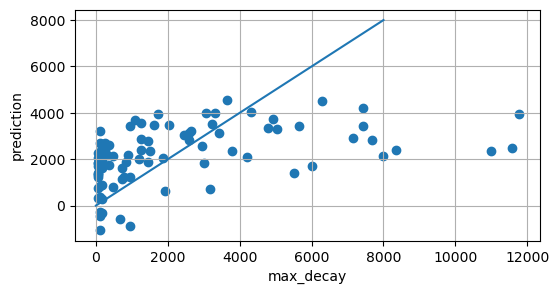

In [53]:
plt.figure(figsize=(6, 3))
plt.scatter(df_all.max_decay, df_all.prediction)
plt.plot(np.arange(0, 8_100, 100), np.arange(0, 8_100, 100))
plt.grid()
plt.xlabel('max_decay')
plt.ylabel('prediction')
plt.show()

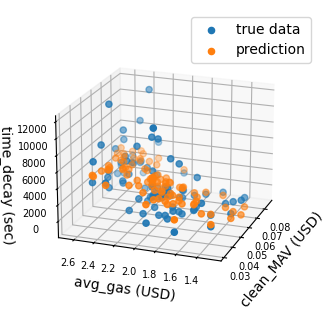

In [60]:
ax = plt.figure(figsize=(7, 4)).add_subplot(projection='3d')

ax.scatter(data_exog.clean_MAV, data_exog.avg_gas, zs=df_test.max_decay, zdir='z', label='true data')
ax.scatter(data_exog.clean_MAV, data_exog.avg_gas, zs=prediction, zdir='z', label='prediction')

# Make legend, set axes limits and labels
ax.legend()
ax.set_xlabel('clean_MAV (USD)')
ax.set_ylabel('avg_gas (USD)')
ax.set_zlabel('time_decay (sec)')

# Customize the view angle so it's easier to see that the scatter points lie
# on the plane y=0
ax.view_init(elev=20., azim=-160, roll=0)
#ax.dist = 11
ax.set_box_aspect(None, zoom=0.85)
ax.tick_params(labelsize=7)
plt.show()